In [8]:
import os
import requests
import re
import time
from io import StringIO
import pandas as pd
import utility as util

def download_daily_broker_volume(stock_id, date):
    print('download_daily_broker_volume', stock_id, date)

    # check if directory exists
    directory = os.path.join('download', 'daily_broker_volume', stock_id)
    util.check_directory(directory)
        
    # if file already downloaded, pass
    file_path = os.path.join(directory, date.strftime('%Y%m%d') + '.csv')
    if os.path.exists(file_path):
        print('**WARRN: already exists')
        return False
    
    # send request
    session = requests.Session()
    while True:
        try:
            viewstate, eventvalidation = get_verify_code(session)
            break # 抓資料成功,進行下一步
        except Exception as e:
            print(e) # 印出無法連線原因
            print('無法拿到資料, 等 31 sec') # server好像會擋30sec
            time.sleep(31)
            continue # 抓資料失敗,重新抓資料
    time.sleep(2)

    payload = {
        '__EVENTTARGET':'',
        '__EVENTARGUMENT':'',
        '__LASTFOCUS':'',
        '__VIEWSTATE' : viewstate,          
        '__EVENTVALIDATION' : eventvalidation,
        'RadioButton_Normal' : 'RadioButton_Normal',
        'TextBox_Stkno' : stock_id,
        'CaptchaControl1 ' : 'Z67YB',
        'btnOK' : '%E6%9F%A5%E8%A9%A2',
        }
    session.post( "https://bsr.twse.com.tw/bshtm/bsMenu.aspx", data=payload, headers=util.HTTP_HEADERS)
    time.sleep(1)

    response = session.get( 'https://bsr.twse.com.tw/bshtm/bsContent.aspx')
    if len(response.text) == 0:
        print('**WARRN: no csv file')
        return False
    response.encoding='big5'

    # save file
    file = open(file_path, 'w', encoding='utf-8-sig')
    file.write(response.text)
    file.close()
    time.sleep(5)
    return True

def get_verify_code(session):
    response = session.get('http://bsr.twse.com.tw/bshtm/bsMenu.aspx', stream=True, verify=False, headers=util.HTTP_HEADERS, timeout=None)
    
    viewstate = re.search('VIEWSTATE"\s+value=.*=', response.text)
    viewstate = viewstate.group()[18:]
    
    eventvalidation = re.search('EVENTVALIDATION"\s+value=.*\w', response.text)
    eventvalidation = eventvalidation.group( )[24:]

    return viewstate, eventvalidation

In [2]:
import datetime
date = datetime.date(2020,8,5)
stock_id = '2317'

download_daily_broker_volume(stock_id, date)

download_daily_broker_volume 2317 2020-08-05


c:\users\mervin\appdata\local\programs\python\python38-32\lib\site-packages\urllib3\connectionpool.py:979: InsecureRequestWarning: Unverified HTTPS request is being made to host 'bsr.twse.com.tw'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  warnings.warn(
c:\users\mervin\appdata\local\programs\python\python38-32\lib\site-packages\urllib3\connectionpool.py:979: InsecureRequestWarning: Unverified HTTPS request is being made to host 'bsr.twse.com.tw'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  warnings.warn(
c:\users\mervin\appdata\local\programs\python\python38-32\lib\site-packages\urllib3\connectionpool.py:979: InsecureRequestWarning: Unverified HTTPS request is being made to host 'bsr.twse.com.tw'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usa

True

In [9]:
import datetime
date = datetime.date(2020,8,5)
stock_id = '2317'

FOREIGN_NAME = ['1470台灣摩根', '8440摩根大通', '1650瑞銀', '1520瑞士信貸', '1440美林', 
                '1560港商野村', '1380台灣匯立', '1590花旗環球', '1480美商高盛', '8960上海匯豐', 
                '1360港麥格理', '1570港商法興']
# def parse_daily_broker_volume(stock_id, date):
print('parse_daily_broker_volume', stock_id, date)

# read file
file_path = os.path.join('download', 'daily_broker_volume', stock_id, date.strftime('%Y%m%d') + '.csv')
if not os.path.exists(file_path):
    print('**WARRN: not exist')
#     return None
file = open(file_path, 'r', encoding='utf-8')
content = file.read()
file.close()

# delete unused table
lines = content.split('\n')
lines = [line for line in lines if len(line.split(',')) == 11]
content = '\n'.join(lines)

# csv to dataframe
df = pd.read_csv(StringIO(content))
df_first = df[df.columns[:5]]
df_second = df[df.columns[6:]]
df_second.columns = df_first.columns
df = df_first.append(df_second).set_index('序號').sort_index().dropna()
df = df.astype({'買進股數':int, '賣出股數':int})
df['買進張數'] = round(df['買進股數'] / 1000)
df['賣出張數'] = round(df['賣出股數'] / 1000)
df_all = df[['券商', '價格', '買進張數', '賣出張數']]

parse_daily_broker_volume 2317 2020-08-05


In [10]:
df = df_all.copy()
df_foreign = df[df['券商'].isin(FOREIGN_NAME)].copy()
df_foreign['買進成本'] = df_foreign.價格 * df_foreign.買進張數 / 10 # 萬
df_foreign['賣出成本'] = df_foreign.價格 * df_foreign.賣出張數 / 10 # 萬
df_broker = df_foreign.groupby('券商').sum()
df_broker['買超張數'] = df_broker.買進張數 - df_broker.賣出張數
df_broker['均買價'] = df_broker.買進成本 / df_broker.買進張數 * 10
df_broker['均賣價'] = df_broker.賣出成本 / df_broker.賣出張數 * 10
df_broker[['均買價', '均賣價']] = df_broker[['均買價', '均賣價']].fillna(0)
for index, row in df_broker.iterrows():
    df_broker.loc[index, '當沖損益'] = min(row['買進張數'], row['賣出張數']) * (row['均賣價'] - row['均買價']) / 10
df_broker[['均買價', '均賣價', '當沖損益']] = df_broker[['均買價', '均賣價', '當沖損益']].applymap(lambda x: "{:.2f}".format(x))
df_broker = df_broker[['買進張數', '賣出張數', '買超張數', '均買價', '均賣價', '當沖損益']]
df_buy = df_broker[df_broker['買超張數'] > 0]
df_sell = df_broker[df_broker['買超張數'] < 0]
display(df_buy.sort_values('買超張數', ascending=False))
display(df_sell.sort_values('買超張數', ascending=True))

,買進張數,賣出張數,買超張數,均買價,均賣價,當沖損益
券商,,,,,,
8440摩根大通,3836.0,2324.0,1512.0,78.19,78.14,-11.63
1520瑞士信貸,3245.0,2069.0,1176.0,78.18,78.19,2.91
1440美林,1739.0,1256.0,483.0,78.29,78.31,1.64
1650瑞銀,589.0,249.0,340.0,78.16,78.29,3.35


,買進張數,賣出張數,買超張數,均買價,均賣價,當沖損益
券商,,,,,,
1380台灣匯立,215.0,3644.0,-3429.0,78.19,78.09,-2.08
1480美商高盛,25.0,1603.0,-1578.0,78.26,78.15,-0.30
1470台灣摩根,488.0,710.0,-222.0,78.17,78.14,-1.63
8960上海匯豐,76.0,277.0,-201.0,78.24,78.10,-1.07
1590花旗環球,283.0,481.0,-198.0,78.16,78.21,1.30
1360港麥格理,92.0,272.0,-180.0,78.34,78.32,-0.22
1560港商野村,41.0,93.0,-52.0,78.40,78.03,-1.53


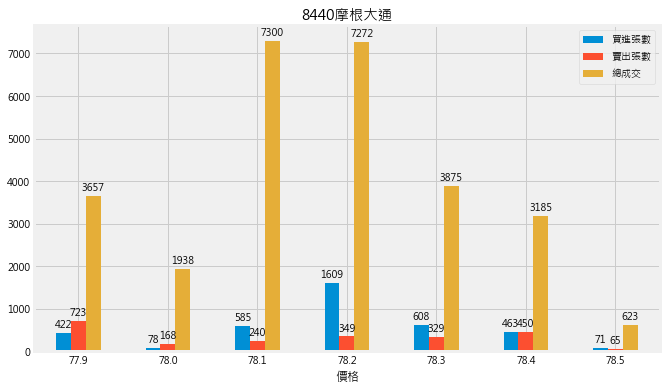

In [15]:
# '1470台灣摩根', '8440摩根大通', '1650瑞銀', '1520瑞士信貸', '1440美林', 
# '1560港商野村', '1380台灣匯立', '1590花旗環球', '1480美商高盛', '8960上海匯豐', 
# '1360港麥格理', '1570港商法興'
broker = '8440摩根大通'

df_price = df_all.groupby('價格').sum()[['買進張數']]
df_price.columns= ['總成交']

df = df_all[df_all['券商'] == broker]

df = pd.merge(df, df_price, on='價格', how='outer').set_index('價格').sort_index()

import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.style.use('fivethirtyeight') # fivethirtyeight, fast
plt.rcParams['font.sans-serif'] = ['Microsoft JhengHei'] # font to handle chinese
%matplotlib inline
plt.rcParams["figure.figsize"] = [10, 6]

ax = df[['買進張數', '賣出張數', '總成交']].plot(kind='bar', title=broker)
plt.xticks(rotation=0)
for p in ax.patches:
    ax.annotate(str(int(p.get_height())), (p.get_x() + p.get_width() / 2, p.get_height()), ha='center', xytext=(0, 5), textcoords="offset points")
